In [80]:
# подключение библиотек

from dotenv import load_dotenv
import os
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
# получение переменных окружения

load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

In [82]:
# получение по API данных о визитах за период: 2023-03-01-2023-09-01 

r_visits = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})
if r_visits.status_code == 200:
    data = r_visits.json()
df_visits = pd.DataFrame(data)

In [83]:
# получение по API данных о регистрациях за период: 2023-03-01-2023-09-01 

r_regs = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})
if r_regs.status_code == 200:
    data = r_regs.json()
df_regs = pd.DataFrame(data)

<h2>Расчет метрик</h2>

На этом этапе проведем расчет конверсии визитов в регистрации, почистим данные визитов от ботов, сагрерируем данные по дате и платформе а также сформируем датафрейм со следующими полями:
- date_group — дата
- platform — платформа (web, ios, android)
- visits — визиты в дату
- registrations — регистрации в дату
- conversion — конверсия.

Полученный датафрейм сохраним в формате JSON.

In [84]:
# очистка данных по визитам

def clean_visits(df):
    df_clean = df.copy()
    
    df_clean['visit_date'] = pd.to_datetime(df['datetime'])
    
    df_clean = df_clean.sort_values(by=['visit_id', 'visit_date']).drop_duplicates(subset=['visit_id'], keep='last')
    df_clean['platform'] = df_clean['platform'].str.strip("`")
    df_clean = df_clean[~df_clean['user_agent'].str.contains('bot')]
    return df_clean
df_clean_visits = clean_visits(df_visits)
df_clean_visits.head()

,visit_id,platform,user_agent,datetime,visit_date
135229,000012d3-f8c7-4257-8999-ad622b703492,android,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,2023-06-06T20:32:30,2023-06-06 20:32:30
236538,0000164b-36eb-409a-8ab4-4acc25e5f3de,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-08-16T11:36:01,2023-08-16 11:36:01
171099,0000190e-e494-4fe1-876f-0dc2b4e1be1c,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-07-02T18:49:04,2023-07-02 18:49:04
258645,000063a2-6a6c-466a-b7e5-781568668a6b,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...,2023-08-29T20:14:40,2023-08-29 20:14:40
170241,0000b829-7f90-4a38-b831-9b314ecfd8b5,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...,2023-07-02T07:20:46,2023-07-02 07:20:46


In [85]:
# очистка данных по регистрациям

def clean_regs(df):
    df_copy = df.copy()
    df_clean = df_copy.drop_duplicates()

    # вместо пустых значений поставить "web", т.к. пустые значение являются признаком органики 
    df_clean['platform'] = df_clean['platform'].fillna('web')
    
    df_clean['reg_date'] = pd.to_datetime(df['datetime'])
    return df_clean
df_clean_regs = clean_regs(df_regs)

In [86]:
# фильтрация и агрегация данных по визитам

def filt_and_agg_visits(df):
    df_clean_visits['date_group'] = df_clean_visits['visit_date'].dt.to_period('D')
    df_agg = df_clean_visits.groupby(['date_group', 'platform']).size().reset_index(name='visits')
    return df_agg
agg_visits = filt_and_agg_visits(df_clean_visits)
agg_visits.head()


,date_group,platform,visits
0,2023-03-01,android,75
1,2023-03-01,ios,22
2,2023-03-01,web,279
3,2023-03-02,android,67
4,2023-03-02,ios,31


In [87]:
# фильтрация и агрегация данных по регистрациям

def filt_and_agg_regs(df):
    df_clean_regs['date_group'] = df_clean_regs['reg_date'].dt.to_period('D')
    df_agg = df_clean_regs.groupby(['date_group', 'platform']).size().reset_index(name='registrations')
    df_agg = df_agg.sort_values(by='date_group')
    return df_agg

agg_regs = filt_and_agg_regs(df_clean_regs)
agg_regs.head()

,date_group,platform,registrations
0,2023-03-01,android,61
1,2023-03-01,ios,18
2,2023-03-01,web,8
3,2023-03-02,android,59
4,2023-03-02,ios,24


In [88]:
# объединение двух датасетов и подсчет конверсии

def merge_dataframes_and_add_conv(df, df1):
    merged_df = pd.merge(df, df1, on=['date_group', 'platform'])
    merged_df['conversion'] = (merged_df['registrations'] / merged_df['visits'] * 100)
    merged_df['date_group'] = merged_df['date_group'].dt.strftime('%Y-%m-%d')
    merged_df.to_json('conversion.json')
    return merged_df

agg_visits_regs = merge_dataframes_and_add_conv(agg_visits, agg_regs)
agg_visits_regs.head()

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355


<h2> Добавление рекламных данных </h2>

Добавим к имеющимся данным данные по рекламным кампаниям, сформируем датафрейм с полями:
- date_group — дата
- visits — визиты на  определенную дату
- registrations — регистрации в определенную дату
- cost — затраты на рекламу (0, если не было затрат)
- utm_campaign — название рекламной кампании (none, если не было в этот период рекламы)

Полученный датафрейм сохраним в формате JSON.

In [89]:
# очистка данных по рекламным кампаниям
ads = pd.read_csv('ads.csv')
ads.head()

,date,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01T10:54:41,google,cpc,advanced_algorithms_series,212
1,2023-03-02T10:32:35,google,cpc,advanced_algorithms_series,252
2,2023-03-03T19:21:40,google,cpc,advanced_algorithms_series,202
3,2023-03-04T17:52:04,google,cpc,advanced_algorithms_series,223
4,2023-03-05T05:35:13,google,cpc,advanced_algorithms_series,265


In [90]:
def clean_ads(df):
    df_copy = df.copy()
    df_clean = df_copy.drop_duplicates()
    df_clean['date'] = pd.to_datetime(df_clean['date'], format='mixed') # тип данных "объект" преобразуем в datetime
    df_clean['date'] = df_clean['date'].dt.to_period('D').dt.start_time.dt.date # удаляем время, оставляем только дату, уст. врем. метки на начало дня
    df_clean = df_clean.rename(columns={'date': 'date_group'})
    df_clean['utm_campaign'] = df_clean['utm_campaign'].fillna('none')
    df_clean['cost'] = df_clean['cost'].fillna('0')
    return  df_clean

clean_ads = clean_ads(ads)
clean_ads.head()   

,date_group,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01,google,cpc,advanced_algorithms_series,212
1,2023-03-02,google,cpc,advanced_algorithms_series,252
2,2023-03-03,google,cpc,advanced_algorithms_series,202
3,2023-03-04,google,cpc,advanced_algorithms_series,223
4,2023-03-05,google,cpc,advanced_algorithms_series,265


In [91]:
def filt_and_agg_ads(df, date1, date2):
    date1 = pd.to_datetime(date1).date()
    date2 = pd.to_datetime(date2).date()
    
    filtered_df=df[(df['date_group'] >= date1) & (df['date_group'] <= date2)]
    df_ads =  filtered_df.groupby(['date_group', 'utm_campaign']).sum(['cost']).reset_index()
    return df_ads

agg_ads = filt_and_agg_ads(clean_ads, DATE_BEGIN, DATE_END)
agg_ads.head()

,date_group,utm_campaign,cost
0,2023-03-01,advanced_algorithms_series,212
1,2023-03-02,advanced_algorithms_series,252
2,2023-03-03,advanced_algorithms_series,202
3,2023-03-04,advanced_algorithms_series,223
4,2023-03-05,advanced_algorithms_series,265


In [92]:
# объединим данные по конверсиям с данными по рекламным кампаниям

def get_conv(df):
    new_conv = df[['date_group', 'visits', 'registrations']]
    new_conv = df.groupby('date_group').agg({'visits': 'sum', 'registrations': 'sum'}).reset_index()
    return new_conv

result_conv = get_conv(agg_visits_regs)
result_conv.head()

,date_group,visits,registrations
0,2023-03-01,376,87
1,2023-03-02,613,106
2,2023-03-03,683,107
3,2023-03-04,647,159
4,2023-03-05,707,115


In [93]:
def get_ads(df1, df2):
    df2['date_group'] = pd.to_datetime(df2['date_group'])
    df1['date_group'] = pd.to_datetime(df1['date_group'])
    ads_and_regs = pd.merge(df1, df2, left_on=['date_group'], right_on=['date_group'], how='left')
    ads_and_regs['utm_campaign'] = ads_and_regs['utm_campaign'].fillna('none')
    ads_and_regs['cost'] = ads_and_regs['cost'].fillna(0)
    ads_and_regs = ads_and_regs.sort_values(by='date_group')
    ads_and_regs.to_json('ads.json')
    return ads_and_regs
    
ads = get_ads(result_conv, agg_ads)
ads.head()

,date_group,visits,registrations,utm_campaign,cost
0,2023-03-01,376,87,advanced_algorithms_series,212.0
1,2023-03-02,613,106,advanced_algorithms_series,252.0
2,2023-03-03,683,107,advanced_algorithms_series,202.0
3,2023-03-04,647,159,advanced_algorithms_series,223.0
4,2023-03-05,707,115,advanced_algorithms_series,265.0


<h2> Визуализация </h2>

In [94]:
# подготовка директории

chart_path = './charts'
os.makedirs(chart_path, exist_ok=True)

<h4>Итоговые визиты</h4>

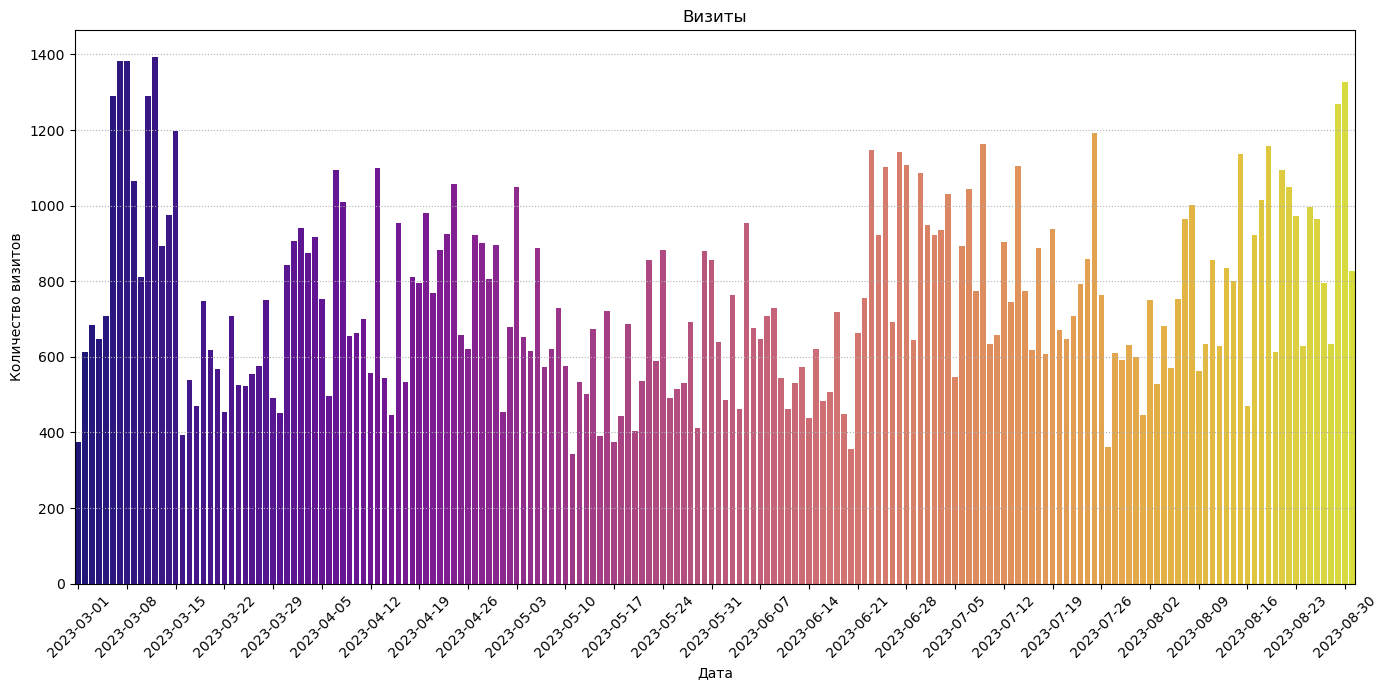

In [95]:
plt.figure(figsize=(14, 7))
sns.barplot(data=result_conv, x='date_group', y='visits', palette='plasma', hue='date_group')
plt.title("Визиты")
plt.xlabel("Дата")
plt.ylabel("Количество визитов")
plt.xticks(rotation=45)
ax = plt.gca()
plt.xticks(ticks=ax.get_xticks()[::7])
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.savefig('./charts/total_visits.png')
plt.show()

<h4> Итоговые визиты с разбивкой по платформам: web, android, ios </h4>

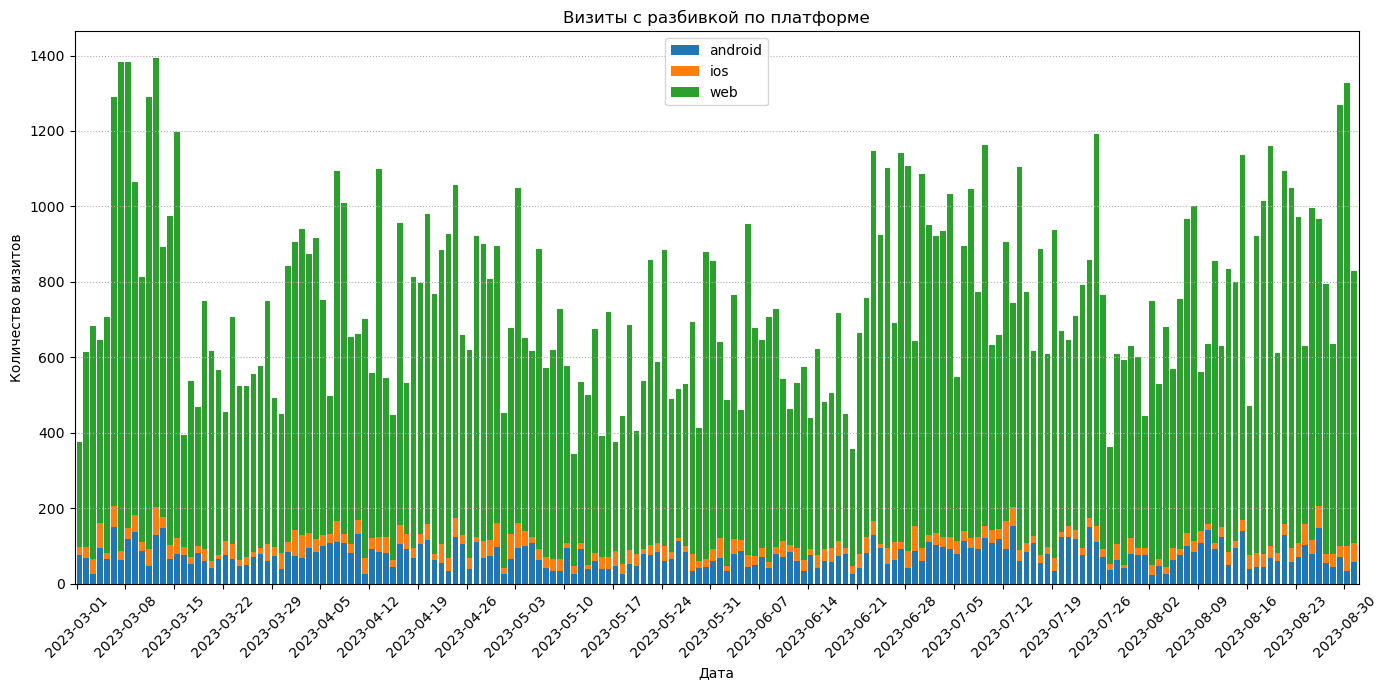

In [96]:
result_visits = agg_visits_regs.pivot_table(index='date_group', columns='platform', values='visits', fill_value=0)
result_visits.plot(kind='bar', stacked=True, figsize=(14, 7), align='edge', width=0.8)
plt.title("Визиты с разбивкой по платформе")
plt.xlabel("Дата")
plt.ylabel("Количество визитов")
plt.xticks(rotation=45)
ax = plt.gca()
plt.xticks(ticks=ax.get_xticks()[::7])
plt.grid(axis='y', linestyle=':')

plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig('./charts/total_visits_by_platform.png')
plt.show()

<h4> Итоговые регистрации </h4>

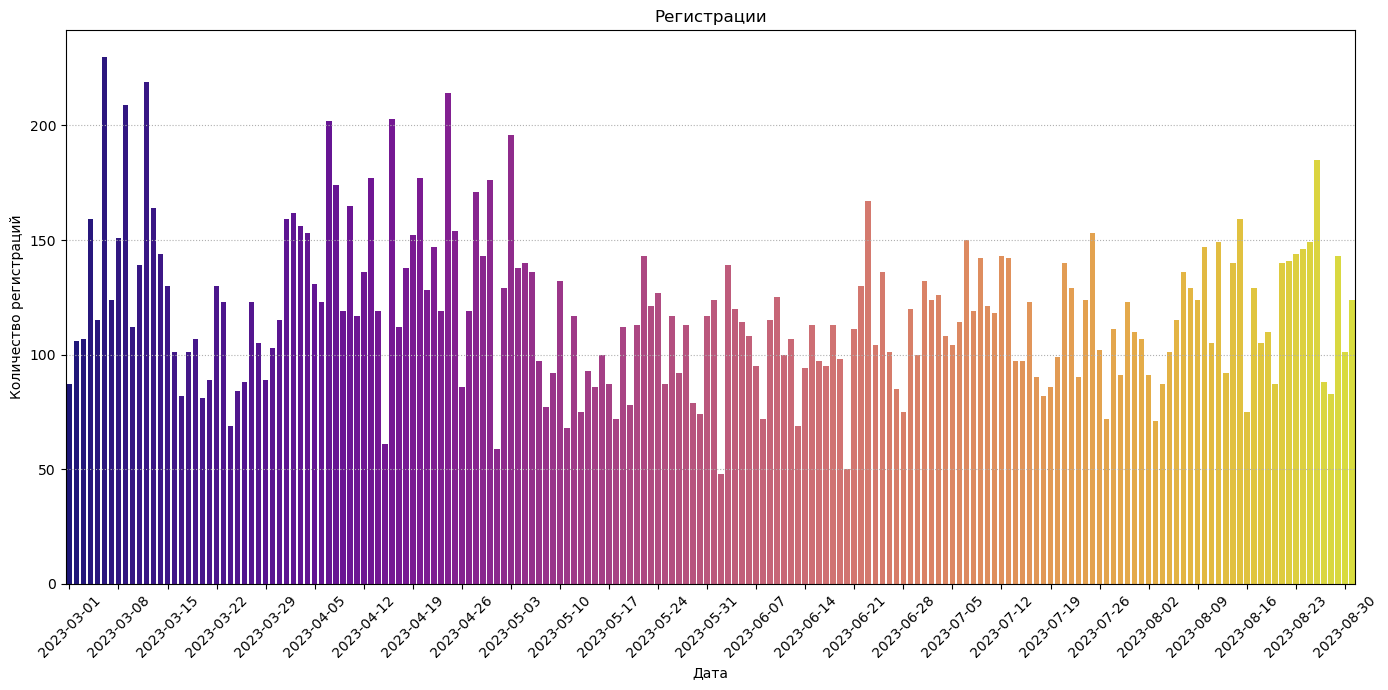

In [97]:
plt.figure(figsize=(14, 7))
sns.barplot(data=result_conv, x='date_group', y='registrations', palette='plasma', hue='date_group')
plt.title("Регистрации")
plt.xlabel("Дата")
plt.ylabel("Количество регистраций")
plt.xticks(rotation=45)
ax = plt.gca()
plt.xticks(ticks=ax.get_xticks()[::7])
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.savefig('./charts/total_registrations.png')
plt.show()

<h4>Итоговые регистрации с разбивкой по платформе: web, android, ios</h4>

In [ ]:
result_regs = agg_visits_regs.pivot_table(index='date_group', columns='platform', values='registrations', fill_value=0)
result_regs.plot(kind='bar', stacked=True, figsize=(14, 7), align='edge', width=0.8)
plt.title("Регистрации с разбивкой по платформе")
plt.xlabel("Дата")
plt.ylabel("Количество регистраций")
plt.xticks(rotation=45)
ax = plt.gca()
plt.xticks(ticks=ax.get_xticks()[::7])
plt.grid(axis='y', linestyle=':')
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig('./charts/total_registrations_by_platform.png')
plt.show()

<h4> Конверсия для android </h4>

In [ ]:
android_conversion = agg_visits_regs.query('platform == "android"')
android_conversion.plot(kind='line', figsize=(14, 7), x='date_group', y='conversion', legend=False)
plt.title("Конверсия для android")
plt.xlabel("Дата")
plt.ylabel("Конверсия, %")
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.savefig('./charts/conversion_android.png')

<h4> Конверсия для ios </h4>

In [ ]:
android_conversion = agg_visits_regs.query('platform == "ios"')
android_conversion.plot(kind='line', figsize=(14, 7), x='date_group', y='conversion', legend=False)
plt.title("Конверсия для ios")
plt.xlabel("Дата")
plt.ylabel("Конверсия, %")
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.savefig('./charts/conversion_ios.png')

<h4> Конверсия для web </h4>

In [ ]:
android_conversion = agg_visits_regs.query('platform == "web"')
android_conversion.plot(kind='line', figsize=(14, 7), x='date_group', y='conversion', legend=False)
plt.title("Конверсия для web")
plt.xlabel("Дата")
plt.ylabel("Конверсия, %")
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.savefig('./charts/conversion_web.png')

<h4> Средняя конверсия </h4>

In [ ]:
result_conversions = agg_visits_regs[['date_group', 'conversion']].groupby('date_group').mean()
result_conversions.plot(kind='line', figsize=(14, 7), legend=False)
plt.title("Общая конверсия")
plt.xlabel("Дата")
plt.ylabel("Конверсия, %")
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.savefig('./charts/conversion.png')

<h4>Стоимость рекламы </h4>

In [ ]:
ads.plot(kind='line', figsize=(14, 7), x='date_group', y='cost', legend=False)
plt.title("Стоимость рекламы")
plt.xlabel("Дата")
plt.ylabel("Стоимость, RUB")
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.savefig('./charts/ads_cost.png')

<h4> Визиты в разрезе рекламных кампаний </h4>

In [ ]:
campaign_periods = ads.groupby(['utm_campaign']).agg(start = ('date_group', 'min'), end = ('date_group', 'max')).reset_index()
campaign_periods.head()

In [ ]:
ads.plot(kind='line', figsize=(14, 7), x='date_group', y='visits', linewidth=0.8, color='black', label='visits', marker='o', markersize=3)
color_map = {
    'advanced_algorithms_series': 'red',
    'intro_to_python_course': 'yellow',
    'ui_ux_design_drive': 'purple',
    'virtual_reality_workshop': 'green',
    'women_in_tech_symposium': 'blue',
    'none': 'white'
}
for _,row in campaign_periods.iterrows():
    plt.axvspan(row['start'], row['end'], label=row['utm_campaign'], color=color_map[row['utm_campaign']], alpha=0.2)

plt.title("Визиты в разрезе рекламных кампаний")
plt.xlabel("Дата")
plt.ylabel("Уникальные визиты")
plt.grid(axis='y', linestyle=':')
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig('./charts/visits_during_marketing.png')

<h4> Регистрации в разрезе рекламных кампаний </h4>

In [ ]:
ads.plot(kind='line', figsize=(14, 7), x='date_group', y='registrations', linewidth=0.8, color='black', label='registrations', marker='o', markersize=3)
color_map = {
    'advanced_algorithms_series': 'red',
    'intro_to_python_course': 'yellow',
    'ui_ux_design_drive': 'purple',
    'virtual_reality_workshop': 'green',
    'women_in_tech_symposium': 'blue',
    'none': 'white'
}
for _,row in campaign_periods.iterrows():
    plt.axvspan(row['start'], row['end'], label=row['utm_campaign'], color=color_map[row['utm_campaign']], alpha=0.2)

plt.title("Регистрации в разрезе рекламных кампаний")
plt.xlabel("Дата")
plt.ylabel("Уникальные пользователи")
plt.grid(axis='y', linestyle=':')
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig('./charts/registrations_during_marketing.png')